In [26]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.metrics import mean_squared_error



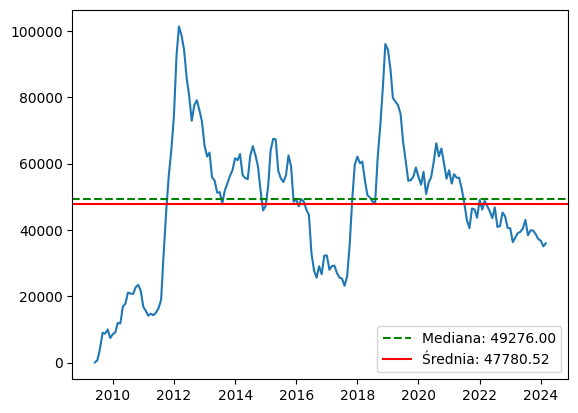

In [39]:
df = pd.read_excel('dane_zadanie_rekrutacyjne.xlsx',sheet_name="dane_telefony")

dzienna_suma_telefonow = df.groupby(df.data_kontaktu.dt.date)['liczba_telefonow'].sum()
dzienna_srednia = dzienna_suma_telefonow.mean()
dzienna_mediana = dzienna_suma_telefonow.median()


plt.plot(dzienna_suma_telefonow)
plt.axhline(y=dzienna_mediana, color='g', linestyle='--', label=f'Mediana: {dzienna_mediana:.2f}')
plt.axhline(y=dzienna_srednia, color='r', linestyle='-', label=f'Średnia: {dzienna_srednia:.2f}')

plt.legend()



In [41]:
df=pd.DataFrame(dzienna_suma_telefonow)
df = df.reset_index()
df.head()
df['data_kontaktu'] = pd.to_datetime(df['data_kontaktu'])
df = df.set_index('data_kontaktu') 




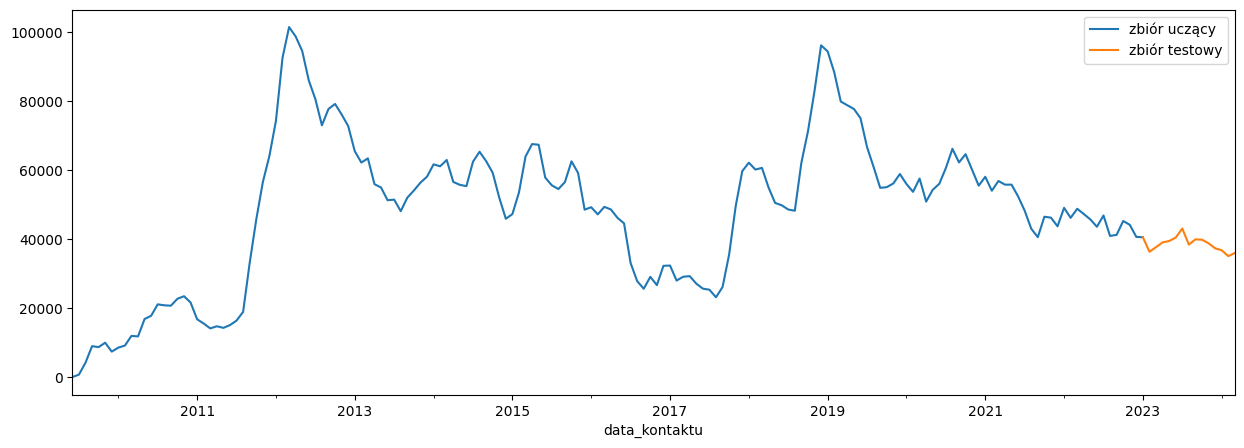

In [42]:


train = df.loc[df.index <= '2023-01-01']
test = df.loc[df.index >= '2023-01-01']

fig, ax =plt.subplots(figsize=(15,5))
train.plot(ax=ax)
test.plot(ax=ax)
ax.legend(["zbiór uczący","zbiór testowy"])
plt.show()



In [43]:
last_year_train = df.loc[(df.index <= '2023-01-01') & (df.index >='2022-01-01')]
y = last_year_train.values
#Zamiana typu data na typ ordinal
X_train = np.array([date.toordinal() for date in last_year_train.index ]).reshape(-1, 1)
X_test = np.array([date.toordinal() for date in test.index]).reshape(-1, 1)
regression = LinearRegression()
regression.fit(X_train,y)
y_hat_train = regression.predict(X_train)
y_hat_test = regression.predict(X_test)



In [115]:
###########CSV Import
# regresja_walicadcja = pd.DataFrame(np.concatenate((last_year_train.index,X_test.index)))
# regresja_walicadcja['estymowana liczba telefonow'] = np.concatenate((y_hat_train,y_hat_test))
# regresja_walicadcja.to_csv("Regresja_walidacja.csv")


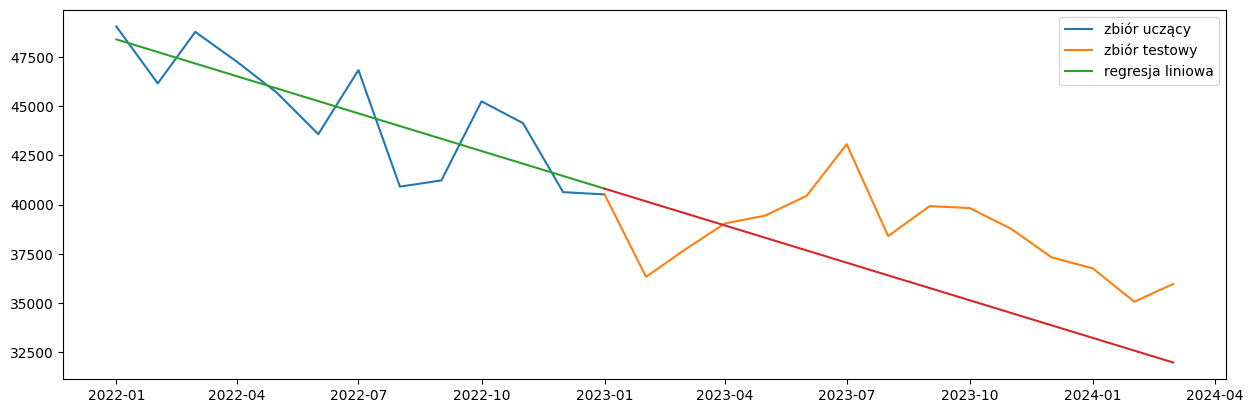

In [45]:
plt.figure().set_figwidth(15)
plt.plot(last_year_train)
plt.plot(test)
plt.plot(last_year_train.index,y_hat_train)
plt.plot(test.index,y_hat_test)
plt.legend(["zbiór uczący","zbiór testowy",'regresja liniowa'])
plt.show()


In [46]:
df2 = pd.read_excel("dane_zadanie_rekrutacyjne.xlsx",sheet_name="dane_produkt")
df2.head()


,paczka_produktow,kategoria_produktu,data_start_sprzedazy,grupa_cenowa_produktu,liczba_produktow
0,PACZKA_10212,KATEGORIA_3,2017-11-01,e. 1500-2000,1406
1,PACZKA_10212,KATEGORIA_3,2017-11-01,c. 500-1000,1257
2,PACZKA_10212,KATEGORIA_3,2017-11-01,f. 2000-3000,1632
3,PACZKA_10212,KATEGORIA_3,2017-11-01,g. 3000-5000,1156
4,PACZKA_10212,KATEGORIA_3,2017-11-01,b. 50-500,451


In [47]:
start_sprzedazy = df2.groupby(df2.data_start_sprzedazy.dt.year)['liczba_produktow'].sum()

start_sprzedazy = pd.DataFrame(start_sprzedazy)
start_sprzedazy.head()

# additional_years = pd.Series([0, 0], index=[2008, 2025])
# start_sprzedazy = pd.concat([start_sprzedazy, additional_years])
# start_sprzedazy = start_sprzedazy.sort_index()
# start_sprzedazy.shift(1).dropna


,liczba_produktow
data_start_sprzedazy,
2009,126470
2011,189994
2013,74489
2014,100985
2015,41922


In [48]:
years = df.index.year.unique()
years = years.append(pd.Index([2008,2025]))
years = pd.DataFrame(years,columns=["data_kontaktu"]).sort_values(by="data_kontaktu")

nowe_produkty_rr = start_sprzedazy.merge(years,left_on='data_start_sprzedazy',right_on='data_kontaktu',how='right').fillna(0)
nowe_produkty_rr['liczba_produktow'] = nowe_produkty_rr['liczba_produktow'].shift(1)
nowe_produkty_rr = nowe_produkty_rr.dropna()
nowe_produkty_rr = nowe_produkty_rr.set_index('data_kontaktu')
nowe_produkty_rr.head()


,liczba_produktow
data_kontaktu,
2009,0.0
2010,126470.0
2011,0.0
2012,189994.0
2013,0.0


In [49]:
df.merge(nowe_produkty_rr,how='inner',left_on=df.index.year,right_on=nowe_produkty_rr.index)['liczba_produktow']


0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
173    0.0
174    0.0
175    0.0
176    0.0
177    0.0
Name: liczba_produktow, Length: 178, dtype: float64

In [50]:
def create_features(df):
    df = df.copy()
    df['day'] = df.index.day
    df['month'] = df.index.quarter
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['new_last_year']=df.merge(nowe_produkty_rr,how='inner',left_on=df.index.year,right_on=nowe_produkty_rr.index)['liczba_produktow'].values
    
    return df

In [51]:
df = create_features(df)
train = create_features(train)
test = create_features(test)

FEATURES = ['day','month','year','dayofyear','new_last_year']
TARGET = ['liczba_telefonow']
df.head()

,liczba_telefonow,day,month,year,dayofyear,new_last_year
data_kontaktu,,,,,,
2009-06-01,49,1,2,2009,152,0.0
2009-07-01,756,1,3,2009,182,0.0
2009-08-01,4207,1,3,2009,213,0.0
2009-09-01,8989,1,3,2009,244,0.0
2009-10-01,8735,1,4,2009,274,0.0


In [52]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

X_full = df[FEATURES]
y_full = df[TARGET]

In [53]:
reg = xgb.XGBRegressor(n_estimators = 1000,early_stopping_rounds = 50)

reg_full = xgb.XGBRegressor(n_estimators = 50)
reg_full.fit(X_full,y_full)

reg.fit(X_train,y_train,
        eval_set = [(X_train,y_train),(X_test,y_test)],
        verbose=True)

[0]	validation_0-rmse:16073.93539	validation_1-rmse:9298.72984
[1]	validation_0-rmse:12366.12986	validation_1-rmse:8234.87517
[2]	validation_0-rmse:9621.90046	validation_1-rmse:7767.54796
[3]	validation_0-rmse:7493.81301	validation_1-rmse:7726.00039
[4]	validation_0-rmse:5997.34525	validation_1-rmse:6865.77443
[5]	validation_0-rmse:5002.00121	validation_1-rmse:6146.12042
[6]	validation_0-rmse:4171.01100	validation_1-rmse:6125.60931
[7]	validation_0-rmse:3537.46123	validation_1-rmse:5517.92124
[8]	validation_0-rmse:3103.76484	validation_1-rmse:5587.71910
[9]	validation_0-rmse:2731.61037	validation_1-rmse:5243.75396
[10]	validation_0-rmse:2430.46995	validation_1-rmse:5143.16386
[11]	validation_0-rmse:2189.52084	validation_1-rmse:4729.92163
[12]	validation_0-rmse:2025.23730	validation_1-rmse:4785.92349
[13]	validation_0-rmse:1933.61446	validation_1-rmse:4427.98956
[14]	validation_0-rmse:1832.13350	validation_1-rmse:4137.83308
[15]	validation_0-rmse:1744.02917	validation_1-rmse:3903.67846


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [54]:
pd.DataFrame(reg.feature_importances_,
            index=reg.feature_names_in_)

,0
day,0.000000
month,0.067975
year,0.385689
dayofyear,0.035326
new_last_year,0.511009


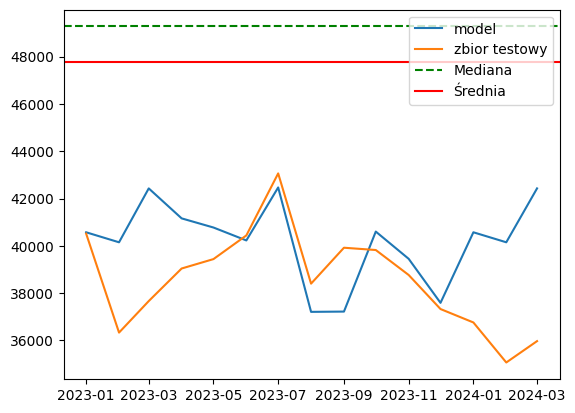

In [119]:
train['prediction'] = reg.predict(X_train)
test['prediction'] = reg.predict(X_test)

# plt.plot(train.index,train['prediction'])
# plt.plot(train.index,train['liczba_telefonow'])
plt.plot(test.index,test['prediction'])
plt.plot(test.index,test['liczba_telefonow'])
plt.axhline(y=dzienna_mediana, color='g', linestyle='--', label=f'Mediana: {dzienna_mediana:.2f}')
plt.axhline(y=dzienna_srednia, color='r', linestyle='-', label=f'Średnia: {dzienna_srednia:.2f}')
plt.legend(['model','zbior testowy','Mediana','Średnia'])





In [123]:
###########CSV Import
# xgb_walidacja = pd.DataFrame(X_test.index)
# xgb_walidacja['prognoza'] = reg.predict(X_test)
# xgb_walidacja.to_csv("XGB_walidacja.csv")

In [122]:
# błąd średnio kwadratowy
wynik_xgb = np.sqrt(mean_squared_error(test['liczba_telefonow'],test['prediction']))
wynik_regresji = np.sqrt(mean_squared_error(y_hat_test,test['liczba_telefonow']))
wynik_mediana = np.sqrt(mean_squared_error([dzienna_mediana]*len(test['liczba_telefonow']), test['liczba_telefonow']))
wynik_srednia = np.sqrt(mean_squared_error([dzienna_srednia]*len(test['liczba_telefonow']), test['liczba_telefonow']))
print("Błąd RMSE przy użyciu XGBOOST:",round(wynik_xgb))
print("Błąd RMSE przy użyciu regresji",round(wynik_regresji))
print("Błąd RMSE przy użyciu mediany",round(wynik_mediana))
print("Błąd RMSE przy użyciu średniej",round(wynik_srednia))

Błąd RMSE przy użyciu XGBOOST: 3010
Błąd RMSE przy użyciu regresji 3380
Błąd RMSE przy użyciu mediany 10899
Błąd RMSE przy użyciu średniej 9433


In [135]:
#T-test
from scipy import stats
predykcja_xgb = np.array(test['prediction'])
predykcja_regresja = y_hat_test
srednia = np.array(test['liczba_telefonow']).mean()
tstatsX, pvalueX = stats.ttest_1samp(predykcja_xgb,srednia)
tstatsR, pvalueR = stats.ttest_1samp(predykcja_regresja,srednia)

print("Pvalue regresja:",pvalueR)
print("Pvalue xgb:",pvalueX )

    

Pvalue regresja: [0.01016958]
Pvalue xgb: 0.002631150948923294


In [73]:
yearday = df.groupby('dayofyear').sum().sort_values(by='liczba_telefonow',ascending=False)

daty_2024 = pd.to_datetime(yearday.index+19722,unit='D')
daty_2024 = daty_2024.set_names([0])
daty_2024 = pd.DataFrame(daty_2024)
daty_2024 = daty_2024.set_index(0).sort_index(ascending=True)


daty_2024 = create_features(daty_2024)
y_2024 = reg_full.predict(daty_2024)
daty_regresja = np.array([date.toordinal() for date in daty_2024.index]).reshape(-1, 1)


In [81]:
############## CSV
# Prognoza_2024_xgb = pd.DataFrame(daty_2024.index)
# Prognoza_2024_xgb['prognoza'] = y_2024
# Prognoza_2024_xgb.to_csv("Prognoza_2024_xgb.csv")

# prognoza_2024_regresja = pd.DataFrame(daty_2024.index)
# prognoza_2024_regresja['prognoza'] = regression.predict(daty_regresja)
# prognoza_2024_regresja.to_csv("Prognoza_2024_regresja.csv")

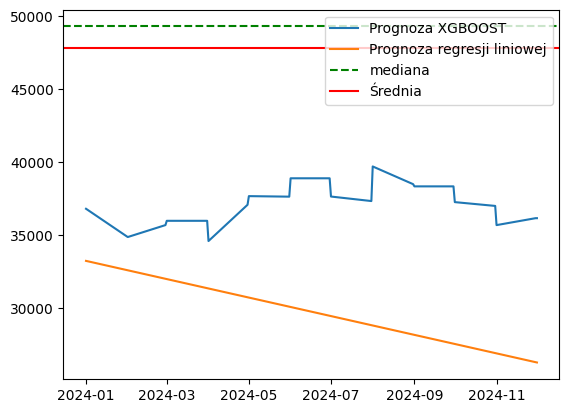

In [172]:

plt.plot(daty_2024.index,y_2024)
plt.plot(daty_2024.index,regression.predict(daty_regresja))
plt.axhline(y=dzienna_mediana, color='g', linestyle='--', label=f'Mediana: {dzienna_mediana:.2f}')
plt.axhline(y=dzienna_srednia, color='r', linestyle='-', label=f'Średnia: {dzienna_srednia:.2f}')
plt.legend(["Prognoza XGBOOST","Prognoza regresji liniowej",'mediana','Średnia'])
